#0. Preparo da Máquina e Bibliotecas

In [0]:
!pip install shapely
!pip install geopandas
!pip install BeautifulSoup4
!pip install thefuzz
!pip install openpyxl
!pip install openai
!pip install svgwrite
!pip install lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/3.1 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 1.6/3.1 MB 10.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.0 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/24.1 MB ? eta -:--:--
   ━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/24.1 MB 11.4 MB/s eta 0:00:02
   ━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/24.1 MB 22.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 23.9/24.1 MB 43.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/9.5 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 104.9 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, regexp_extract, concat
import requests
import tempfile
import json
import io
import os
from functools import reduce

import pandas as pd

import shapely
import geopandas as gpd

import matplotlib.font_manager as fm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

from lxml import etree
from PIL import Image, ImageDraw, ImageFont
import svgwrite

from openai import OpenAI

client = OpenAI(api_key=os.environ['GPT_key'])

spark = SparkSession.builder.getOrCreate()

#1. Objetivo

O objetivo do presente trabalho é dar uma resposta rápida e eficiente do contexto de cada município em seu contexto socio-econômico. A proposta é que seja uma ferramente integradora que concentre diferentes indicadores sobre cada cidade, que hoje estão dispersos em diferentes fontes.

Algumas perguntas que esperam ser respondidas através da solução:
1. Onde a cidade está localizada?
2. Qual o IDH do município? Isso o coloca em qual posição no cenário Brasileiro?
3. Em qual setor a economia está mais aquecida?
4. Qual o tamanho da população e densidade demográfica?

Respondendo essas pergunta, será possível entender qual o contexto daquele lugar que se busca conhecer.


# 2. ETL

Os dados foram centralizadas em um [repositório do GitHub](https://github.com/fersondahl-uff/MVP_eng_dados/) para facilitar a coleta. De toda maneira, os dados serão organizados no Catalog em diferente camadas:
- Bronze: Os dados originais
- Silver: Dados após os primeiros tratamentos
- Gold: Dados finais que serão utilizados no processo de análise

### 2.1 Shape dos municípios

Nessa dimensão, será possível tanto obter informações espaciais sobre o município como plotar o mapa dos locais. Os arquivos originais estão dispiníveis no _site_ do IBGE ([Malha Municipal](https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais/15774-malhas.html)).

#### 2.1.1 Bronze

Para a coleta, os dados foram particionados por município para reduzir o tamanho dos arquivos. Após a carga, é gerada a tabela sem alterações na camada **Bronze**.

In [0]:
##### Arquivo com o mapa dos municípios brasileiros
# Seleciona todos os arquivos na pasta de mapa
url = f"https://api.github.com/repos/fersondahl-uff/MVP_eng_dados/contents/Brasil Geo?ref=main"
mapa_br_ufs = requests.get(url).json()

mapas = pd.DataFrame(mapa_br_ufs)

# Lê os arquivos
geo_df = []
for ind, mapa in mapas.iterrows():
    geo_df.append(pd.read_parquet(mapa['download_url'], engine='pyarrow'))


# Cria df Spark
df_munc = spark.createDataFrame(pd.concat(geo_df))


# Cria tabela bronze de municípios no catalog
df_munc.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("mvp_catalog.bronze.municipios")

#### 2.1.2 Silver

Para facilitar futuros ***JOINs***, é inserida a coluna de sigla da UF na tabela. Após essa inserção, a nova dimensão é gerada na camada silver.

In [0]:

siglas = pd.DataFrame([
  {"NM_UF": "Acre", "Sigla": "AC"},
  {"NM_UF": "Alagoas", "Sigla": "AL"},
  {"NM_UF": "Amapá", "Sigla": "AP"},
  {"NM_UF": "Amazonas", "Sigla": "AM"},
  {"NM_UF": "Bahia", "Sigla": "BA"},
  {"NM_UF": "Ceará", "Sigla": "CE"},
  {"NM_UF": "Distrito Federal", "Sigla": "DF"},
  {"NM_UF": "Espírito Santo", "Sigla": "ES"},
  {"NM_UF": "Goiás", "Sigla": "GO"},
  {"NM_UF": "Maranhão", "Sigla": "MA"},
  {"NM_UF": "Mato Grosso", "Sigla": "MT"},
  {"NM_UF": "Mato Grosso do Sul", "Sigla": "MS"},
  {"NM_UF": "Minas Gerais", "Sigla": "MG"},
  {"NM_UF": "Pará", "Sigla": "PA"},
  {"NM_UF": "Paraíba", "Sigla": "PB"},
  {"NM_UF": "Paraná", "Sigla": "PR"},
  {"NM_UF": "Pernambuco", "Sigla": "PE"},
  {"NM_UF": "Piauí", "Sigla": "PI"},
  {"NM_UF": "Rio de Janeiro", "Sigla": "RJ"},
  {"NM_UF": "Rio Grande do Norte", "Sigla": "RN"},
  {"NM_UF": "Rio Grande do Sul", "Sigla": "RS"},
  {"NM_UF": "Rondônia", "Sigla": "RO"},
  {"NM_UF": "Roraima", "Sigla": "RR"},
  {"NM_UF": "Santa Catarina", "Sigla": "SC"},
  {"NM_UF": "São Paulo", "Sigla": "SP"},
  {"NM_UF": "Sergipe", "Sigla": "SE"},
  {"NM_UF": "Tocantins", "Sigla": "TO"}
])


munc_silver = spark.read.table("mvp_catalog.bronze.municipios").toPandas()
munc_silver = pd.merge(left=munc_silver, right=siglas, how='left', on='NM_UF')


# Cria tabela silver de municípios no catalog
spark.createDataFrame(munc_silver).write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("mvp_catalog.silver.municipios")

munc_silver.head(10)


,CD_MUN,NM_MUN,CD_RGI,NM_RGI,CD_RGINT,NM_RGINT,CD_UF,NM_UF,CD_REGIAO,NM_REGIAO,CD_CONCURB,NM_CONCURB,AREA_KM2,geometry,Sigla
0,5204409,Caiapônia,520011,Jataí-Mineiros,5203,Rio Verde,52,Goiás,5,Centro-oeste,None,None,8627.961,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xfa.\x0...,GO
1,5204508,Caldas Novas,520008,Caldas Novas-Morrinhos,5202,Itumbiara,52,Goiás,5,Centro-oeste,None,None,1608.523,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x8d\x18...,GO
2,5204557,Caldazinha,520001,Goiânia,5201,Goiânia,52,Goiás,5,Centro-oeste,5208707,Goiânia/GO,251.720,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xd0\x0e...,GO
3,5204607,Campestre de Goiás,520015,Palmeiras de Goiás,5204,São Luís de Montes Belos - Iporá,52,Goiás,5,Centro-oeste,None,None,272.734,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xd5\x11...,GO
4,5204656,Campinaçu,520016,Porangatu,5205,Porangatu - Uruaçu,52,Goiás,5,Centro-oeste,None,None,1978.386,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x1a\x1a...,GO
5,5204706,Campinorte,520017,Uruaçu - Niquelândia,5205,Porangatu - Uruaçu,52,Goiás,5,Centro-oeste,None,None,1064.541,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x99\x0c...,GO
6,5204805,Campo Alegre de Goiás,520004,Catalão,5201,Goiânia,52,Goiás,5,Centro-oeste,None,None,2450.111,b'\x01\x03\x00\x00\x00\x01\x00\x00\x009\x13\x0...,GO
7,5204854,Campo Limpo de Goiás,520002,Anápolis,5201,Goiânia,52,Goiás,5,Centro-oeste,None,None,156.113,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xed\x04...,GO
8,5204904,Campos Belos,520021,Posse-Campos Belos,5206,Luziânia - Águas Lindas de Goiás,52,Goiás,5,Centro-oeste,None,None,735.126,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00T$\x00\x...,GO
9,5204953,Campos Verdes,520018,Ceres - Rialma - Goianésia,5205,Porangatu - Uruaçu,52,Goiás,5,Centro-oeste,None,None,443.125,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x8b\x14...,GO


### 2.2 PIB por município

Na consulta de PIB por município, é possível entender a escala de produção de cada cidade e quanto de valor é adicionado por cada setor. Os dados originais podem ser consultados através de [Sidra IBGE](https://sidra.ibge.gov.br/tabela/5938), ou utilizando a requisição https://apisidra.ibge.gov.br/values/t/5938/n6/all/v/37,513,517,525,6575/p/last%201/d/v37%202,v513%202,v517%202,v525%202,v6575%202.

#### 2.2.1 Bronze

In [0]:
pib_munc = pd.read_parquet("https://github.com/fersondahl-uff/MVP_eng_dados/raw/refs/heads/main/Pib%20Municipios.parquet")

bronze_pib_munc = spark.createDataFrame(pib_munc)
# Cria dimensão bronze do arquivo
bronze_pib_munc.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("mvp_catalog.bronze.pib")

bronze_pib_munc.show(truncate=False)

+--------------------------+-----------------+--------------------------+-----------------+----------+------------------+--------------------------+-----------------+--------------------------------------------------------------------------------------------------------------------------------------+------------+----+
|NC                        |NN               |MC                        |MN               |V         |D1C               |D1N                       |D2C              |D2N                                                                                                                                   |D3C         |D3N |
+--------------------------+-----------------+--------------------------+-----------------+----------+------------------+--------------------------+-----------------+--------------------------------------------------------------------------------------------------------------------------------------+------------+----+
|Nível Territorial (Código)|Nível Territ

#### 2.2.2 Silver

Na camada silver, a estrutura dos dados brutos é completamente alterada. A tabela é pivotada para que esteja orientada em relação aos municípios e se relacione diratemente seus indicadores de produção.

In [0]:
pib_munc_silver = pib_munc.copy()

#Acerta o cabeçalho da consulta
pib_munc_silver.columns = pib_munc_silver.iloc[0]
pib_munc_silver = pib_munc_silver[1:].reset_index(drop=True)


#Pivota tabela para facilitar análise posterior
pib_munc_silver = pib_munc_silver.pivot(index=['Município (Código)', 'Município', 'Ano'], columns='Variável', values='Valor')

# Renomeia colunas de valor e converte para float
values_columns = ['pib', 'valor_adc_serv_essenciais_pub', 'valor_adc_agropecuaria', 'valor_adc_industria', 'valor_adc_servicos']
pib_munc_silver.columns = values_columns

for col in values_columns:
    pib_munc_silver[col] = pib_munc_silver[col].astype(float)

# Renomeia demais colunas e calcula valor adicionado total
pib_munc_silver = pib_munc_silver.reset_index().rename(columns={'Município (Código)':'cod_munc'})

pib_munc_silver['valor_adicionado_total'] = pib_munc_silver[['valor_adc_serv_essenciais_pub', 'valor_adc_agropecuaria', 'valor_adc_industria', 'valor_adc_servicos']].sum(axis=1)


# Cria df spark
silver_df_pib = spark.createDataFrame(pib_munc_silver)

# Write to Unity Catalog (Delta Table)
silver_df_pib.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("mvp_catalog.silver.pib")

silver_df_pib.show(truncate=False)


+--------+-----------------------------+----+-------------+-----------------------------+----------------------+-------------------+------------------+----------------------+
|cod_munc|Município                    |Ano |pib          |valor_adc_serv_essenciais_pub|valor_adc_agropecuaria|valor_adc_industria|valor_adc_servicos|valor_adicionado_total|
+--------+-----------------------------+----+-------------+-----------------------------+----------------------+-------------------+------------------+----------------------+
|1100015 |Alta Floresta D'Oeste - RO   |2021|734469.33    |173121.63                    |311468.68             |27847.19           |172435.42         |684872.92             |
|1100023 |Ariquemes - RO               |2021|3209761.4    |782306.22                    |293000.78             |406329.13          |1307929.92        |2789566.05            |
|1100031 |Cabixi - RO                  |2021|238411.63    |46579.25                     |136659.3              |8115.02      

### 2.4 IDH dos Municípios

É adicionada também a consulta do indicador de IDH por município. Os dados originais estão disponíveis no site do PNUD em [IDHM Municípios 2010](https://www.undp.org/pt/brazil/idhm-municipios-2010).

#### 2.4.1 Bronze

In [0]:

idh_bronze = spark.createDataFrame(pd.read_csv("https://github.com/fersondahl-uff/MVP_eng_dados/raw/refs/heads/main/munc_IDH.csv").rename(
  columns=lambda x: x.strip().replace(' ','_').replace('(','').replace(')','').replace(',','')))


# Cria dimensão bronze do IDH
idh_bronze.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("mvp_catalog.bronze.idh")


idh_bronze.show(truncate=False)

+-----------------+------------------------+---------+-------------+---------------------+------------------+
|Ranking_IDHM_2010|Município               |IDHM_2010|IDHMRenda2010|IDHM_Longevidade_2010|IDHM_Educação_2010|
+-----------------+------------------------+---------+-------------+---------------------+------------------+
|1 º              |São Caetano do Sul (SP) |0,862    |0,891        |0,887                |0,811             |
|2 º              |Águas de São Pedro (SP) |0,854    |0,849        |0,890                |0,825             |
|3 º              |Florianópolis (SC)      |0,847    |0,870        |0,873                |0,800             |
|4 º              |Balneário Camboriú (SC) |0,845    |0,854        |0,894                |0,789             |
|4 º              |Vitória (ES)            |0,845    |0,876        |0,855                |0,805             |
|6 º              |Santos (SP)             |0,840    |0,861        |0,852                |0,807             |
|7 º      

#### 2.4.2 Silver

A consulta de IDHM não possui o código IBGE dos municípios, o que dificulta relações futuras. Para contornar o problema, a informação foi adicionada na consulta, utilizando como base a própria camada de municípios da etapa 2.1. Para isso, foi realizado um _merge_ (_join_) através do nome e UF da cidade. Como há diferentes escritas em alguns casos, foi feita uma segunda tentativa utilizando um _merge fuzz_.

In [0]:
from thefuzz import process

idh_ajuste = spark.read.table("mvp_catalog.bronze.idh").toPandas()

for col in ['IDHM_2010', 'IDHMRenda2010',
       'IDHM_Longevidade_2010', 'IDHM_Educação_2010']:

    idh_ajuste[col] = idh_ajuste[col].apply(lambda linha: linha.replace(',','.')).astype(float)


### Traz o código do município através da base de shape dos municipios gerada na etapa 2.1.2
muncs = spark.read.table("mvp_catalog.silver.municipios").select("NM_MUN", "Sigla", 'CD_MUN').toPandas()
muncs['NM_MUN'] = muncs['NM_MUN'].apply(lambda linha: linha.lower())

idh_ajuste['Sigla'] = idh_ajuste['Município'].apply(lambda linha: linha.split(" (")[-1].replace(")", "").strip())
idh_ajuste['NM_MUN'] = idh_ajuste['Município'].apply(lambda linha: " ".join(linha.split(" ")[:-1]).strip().lower())

# JOIN através dos municípios com nome e sigla iguais
first_name_merge = pd.merge(left=idh_ajuste, right=muncs, how='left', on=['NM_MUN', 'Sigla'])

#Merge com fuzzy para municípios faltantes com nome parecido com os não correlacionados ainda
restantes = first_name_merge.copy()[first_name_merge['CD_MUN'].isna()]

merged_muncs = first_name_merge.dropna(subset='CD_MUN')['CD_MUN'].to_list()

nm_padrao = muncs[muncs['CD_MUN'].apply(lambda linha: linha in merged_muncs) == False]['NM_MUN'].tolist()
restantes["NM_MUN"] = restantes["NM_MUN"].apply(
    lambda linha: process.extractOne(linha, nm_padrao, score_cutoff=80)[0] if process.extractOne(linha, nm_padrao, score_cutoff=80) else linha
)


restantes = pd.merge(left=restantes.drop('CD_MUN', axis=1), right=muncs, how='left', on=['NM_MUN', 'Sigla'])

#Consolidação dos dados
idh_silver = pd.concat([first_name_merge.dropna(subset='CD_MUN'), restantes], axis=0)


idh_silver['CD_MUN'] = idh_silver['CD_MUN'].astype(int, errors='ignore')


idh_silver = spark.createDataFrame(idh_silver)

# Cria dimensão silver do IDH
idh_silver.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("mvp_catalog.silver.idh")


idh_silver.show(truncate=False)


+-----------------+-----------------------------+---------+-------------+---------------------+------------------+-----+------------------------+-------+
|Ranking_IDHM_2010|Município                    |IDHM_2010|IDHMRenda2010|IDHM_Longevidade_2010|IDHM_Educação_2010|Sigla|NM_MUN                  |CD_MUN |
+-----------------+-----------------------------+---------+-------------+---------------------+------------------+-----+------------------------+-------+
|4638 º           |Limoeiro de Anadia (AL)      |0.58     |0.575        |0.742                |0.457             |AL   |limoeiro de anadia      |2704203|
|4638 º           |Fervedouro (MG)              |0.58     |0.583        |0.796                |0.42              |MG   |fervedouro              |3125952|
|4638 º           |Paraibano (MA)               |0.58     |0.572        |0.723                |0.473             |MA   |paraibano               |2107704|
|4638 º           |Indiaroba (SE)               |0.58     |0.533        |0.7

### 2.4 População dos Municípios

A presente camada também está disponível a partir dos dados do IBGE, em que estima-se a população total de cada município. A base está disponível em [Estimativas de População](https://www.ibge.gov.br/estatisticas/sociais/populacao/9103-estimativas-de-populacao.html).

### 2.4.1 Bronze

In [0]:
df_populacao = pd.read_excel("https://github.com/fersondahl-uff/MVP_eng_dados/raw/refs/heads/main/POP2024_20241230.xlsx", sheet_name='MUNICÍPIOS', header=1, dtype='str')[:5571]


df_populacao_bronze = spark.createDataFrame(df_populacao.rename(columns=lambda x: x.replace('.', '_').replace(' ', '_')))

# Cria dimensão bronze da População
df_populacao_bronze.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("mvp_catalog.bronze.populacao")


df_populacao_bronze.show(truncate=False)

+---+-------+----------+------------------------+------------------+----------+
|UF |COD__UF|COD__MUNIC|NOME_DO_MUNICÍPIO       |POPULAÇÃO_ESTIMADA|Unnamed:_5|
+---+-------+----------+------------------------+------------------+----------+
|RO |11     |00015     |Alta Floresta D'Oeste   |22853             |NULL      |
|RO |11     |00023     |Ariquemes               |108573            |NULL      |
|RO |11     |00031     |Cabixi                  |5690              |NULL      |
|RO |11     |00049     |Cacoal                  |97637             |NULL      |
|RO |11     |00056     |Cerejeiras              |16975             |NULL      |
|RO |11     |00064     |Colorado do Oeste       |16588             |NULL      |
|RO |11     |00072     |Corumbiara              |8001              |NULL      |
|RO |11     |00080     |Costa Marques           |13522             |NULL      |
|RO |11     |00098     |Espigão D'Oeste         |32717             |NULL      |
|RO |11     |00106     |Guajará-Mirim   

#### 2.4.2 Silver

Para o tratamento da tabela de População foi gerada a coluna de código do Município seguindo o padrão das demais, além da formatação da coluna de população estimada como número inteiro.

In [0]:
df_populacao_silver = spark.read.table("mvp_catalog.bronze.populacao")

df_populacao_silver = df_populacao_silver.withColumn("CD_MUN", concat(df_populacao_silver["COD__UF"], df_populacao_silver["COD__MUNIC"])).withColumn(
    "POPULAÇÃO_ESTIMADA", df_populacao_silver["POPULAÇÃO_ESTIMADA"].cast("int"))

# Cria dimensão silver da População
df_populacao_silver.select('UF', 'NOME_DO_MUNICÍPIO', 'CD_MUN', 'POPULAÇÃO_ESTIMADA').write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("mvp_catalog.silver.populacao")


df_populacao_silver.select('UF', 'NOME_DO_MUNICÍPIO', 'CD_MUN', 'POPULAÇÃO_ESTIMADA').show(truncate=False)

+---+------------------------+-------+------------------+
|UF |NOME_DO_MUNICÍPIO       |CD_MUN |POPULAÇÃO_ESTIMADA|
+---+------------------------+-------+------------------+
|RS |Barra do Quaraí         |4301875|4337              |
|RS |Barra do Ribeiro        |4301909|12475             |
|RS |Barra do Rio Azul       |4301925|1724              |
|RS |Barra Funda             |4301958|2555              |
|RS |Barros Cassal           |4302006|9442              |
|RS |Benjamin Constant do Sul|4302055|2120              |
|RS |Bento Gonçalves         |4302105|127775            |
|RS |Boa Vista das Missões   |4302154|1969              |
|RS |Boa Vista do Buricá     |4302204|7125              |
|RS |Boa Vista do Cadeado    |4302220|2271              |
|RS |Boa Vista do Incra      |4302238|2315              |
|RS |Boa Vista do Sul        |4302253|2815              |
|RS |Bom Jesus               |4302303|11431             |
|RS |Bom Princípio           |4302352|13650             |
|RS |Bom Progr

### 2.6 Silver Schema

Na estruturação da camada _silver_ do _Datalake_ foi utilizado o conceito do _StarSchema_. A dimensão municípios no centro se relaciona com as demais entidades de População, IDH e PIB.

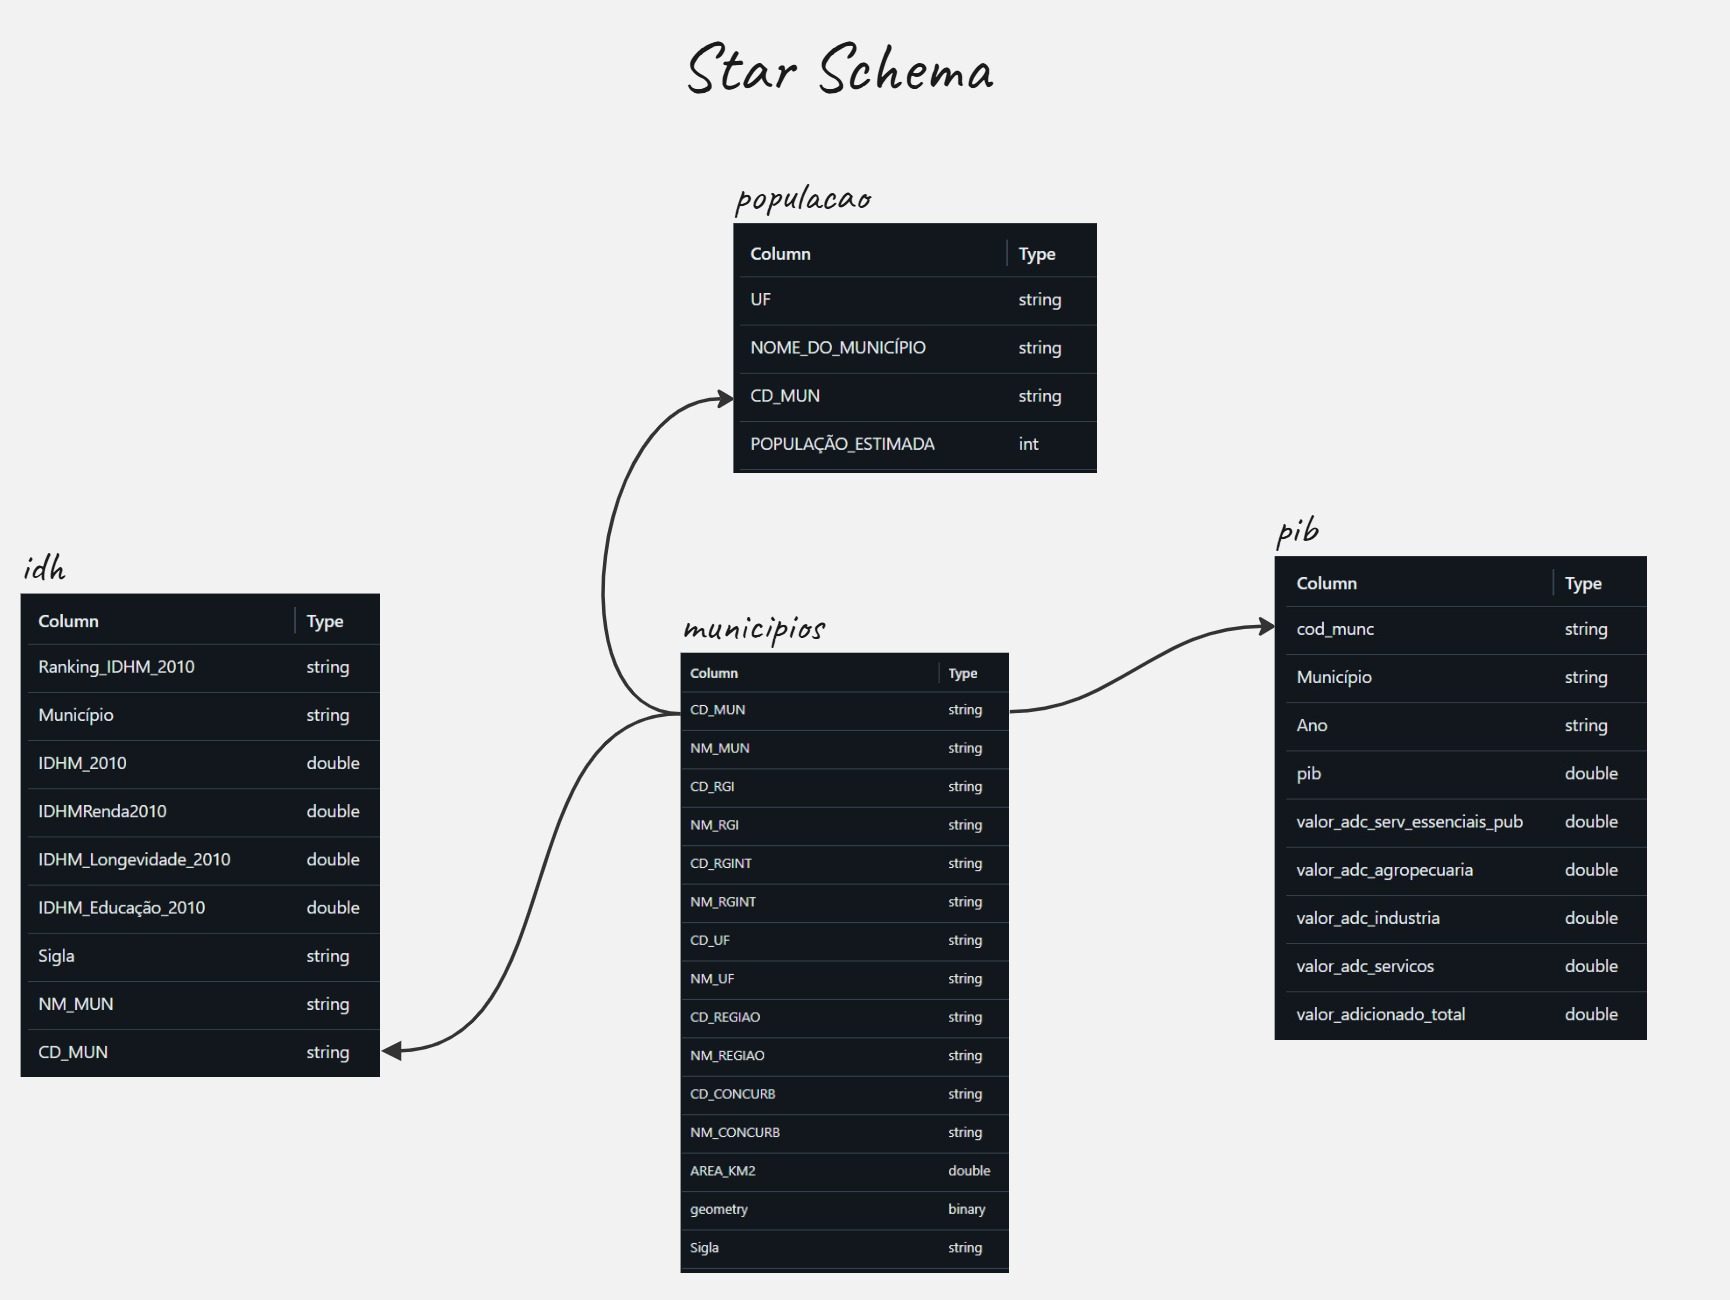

In [0]:
# Imagem do Schema
img_url = requests.get(r"https://raw.githubusercontent.com/fersondahl-uff/MVP_eng_dados/refs/heads/main/Assets/silver%20schema.jpg")
img_url.raise_for_status()
img_buf = io.BytesIO(img_url.content)
img = Image.open(img_buf)
display(img)


### 2.7 Gold Schema

O _Gold Schema_ conterá apenas uma dimensão, a partir de múltiplos _join's_ das tabelas contidas na camada _Silver_. Dessa maneira, não mais se usa a modelagem do _Star Schema_, mas parte-se para um _Flat Schema_.  

In [0]:
### munc
gold_munc = spark.read.table('mvp_catalog.silver.municipios').select('CD_MUN', 'NM_MUN',
       'NM_UF', 'Sigla', 'NM_REGIAO', 'AREA_KM2', 'geometry')

### PIB
gold_pib = spark.read.table('mvp_catalog.silver.pib').select(['cod_munc', 'pib', 'valor_adc_serv_essenciais_pub',
       'valor_adc_agropecuaria', 'valor_adc_industria', 'valor_adc_servicos',
       'valor_adicionado_total']).withColumnRenamed("cod_munc", "CD_MUN")

### População
gold_pop = spark.read.table('mvp_catalog.silver.populacao').select("CD_MUN", "POPULAÇÃO_ESTIMADA")

### IDH
gold_idh = spark.read.table('mvp_catalog.silver.idh').select(['IDHM_2010','CD_MUN'])

# Bases concatenadas
gold_dfs = [gold_munc, gold_pib, gold_pop, gold_idh]
gold_df_merged = reduce(lambda df_left, df_right: df_left.join(df_right, on="CD_MUN", how="left"), gold_dfs)

gold_df_merged = gold_df_merged.withColumn('densidade_demografica', gold_df_merged['POPULAÇÃO_ESTIMADA']/      gold_df_merged['AREA_KM2']).withColumn('CD_MUN', gold_df_merged['CD_MUN'].cast('int'))

# Cria dimensão ouro com as informações concatenadas
gold_df_merged.write.format("delta") \
    .mode("overwrite") \
    .option('overwriteSchema', 'true') \
    .saveAsTable("mvp_catalog.gold.munc_infos")



gold_df_merged.toPandas()

,CD_MUN,NM_MUN,NM_UF,Sigla,NM_REGIAO,AREA_KM2,geometry,pib,valor_adc_serv_essenciais_pub,valor_adc_agropecuaria,valor_adc_industria,valor_adc_servicos,valor_adicionado_total,POPULAÇÃO_ESTIMADA,IDHM_2010,densidade_demografica
0,5204409,Caiapônia,Goiás,GO,Centro-oeste,8627.961,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xfa.\x0...,821652.98,100734.08,432944.02,45808.30,196172.04,775658.44,16655,0.693,1.930352
1,5204508,Caldas Novas,Goiás,GO,Centro-oeste,1608.523,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x8d\x18...,3000885.82,548074.31,304223.58,523707.65,1386508.35,2762513.89,104788,0.733,65.145478
2,5204557,Caldazinha,Goiás,GO,Centro-oeste,251.720,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xd0\x0e...,84638.41,24675.06,23979.21,4724.73,24251.11,77630.11,4735,0.685,18.810583
3,5204607,Campestre de Goiás,Goiás,GO,Centro-oeste,272.734,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xd5\x11...,72736.71,23067.36,25998.95,3866.67,16343.18,69276.16,3854,0.653,14.130985
4,5204656,Campinaçu,Goiás,GO,Centro-oeste,1978.386,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x1a\x1a...,110499.80,30366.13,47630.30,2674.04,23749.77,104420.24,3758,0.631,1.899528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,2410603,Rafael Godeiro,Rio Grande do Norte,RN,Nordeste,100.073,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x93\x00...,43451.39,25055.13,3293.36,3793.80,9583.89,41726.18,3008,0.654,30.058058
5566,2410702,Riacho da Cruz,Rio Grande do Norte,RN,Nordeste,127.223,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xc5\x00...,37507.56,24804.64,1939.42,1679.01,7704.06,36127.13,2741,0.584,21.544846
5567,2410801,Riacho de Santana,Rio Grande do Norte,RN,Nordeste,128.106,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x80\x00...,43513.57,28696.61,2802.13,1136.23,9478.26,42113.23,4243,0.591,33.121009
5568,2410900,Riachuelo,Rio Grande do Norte,RN,Nordeste,262.887,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00=\x00\x0...,192157.80,53626.47,2108.19,84834.04,39733.47,180302.17,7627,0.592,29.012465


# 3. Análise da qualidade dos dados

In [0]:
df_municipios = spark.read.table("mvp_catalog.gold.munc_infos").toPandas()
df_municipios['geometry'] = df_municipios['geometry'].apply(lambda wkb_bytes: shapely.wkb.loads(wkb_bytes) if  wkb_bytes else None)

dimensions = pd.DataFrame.from_dict(df_municipios.dtypes.to_dict(), orient='index', columns=['type']).rename_axis('column').reset_index()

#### 3.1 Descrição dos dados

Na consulta a seguir é possível observar métricas relacionadas aos dados, o domínio e a presença de registros faltantes para as colunas numéricas e de texto.

In [0]:

## Descrição das colunas de texto
str_dimensions = dimensions.copy()[dimensions['type'] == pd.StringDtype]

str_describe = df_municipios[str_dimensions.column.to_list()].describe().T[['count', 'unique']].rename_axis(
    'column').reset_index()
str_dimensions = pd.merge(left=str_dimensions, right=str_describe, on='column', how='left')

dominios_str = {'dominio':{'NM_REGIAO':['Sul', 'Sudeste', 'Nordeste', 'Norte', 'Centro-oeste'],
                'Sigla':siglas.Sigla.to_list(), 'NM_MUN':'Municípios BR', 'NM_UF':'UFs BR'}}


dominios_str_df = pd.DataFrame(dominios_str).rename_axis('column').reset_index()

str_dimensions = pd.merge(left=str_dimensions, right=dominios_str_df, on='column', how='left').fillna('-')

## Descrição das colunas numéricas
numeric_columns = dimensions[dimensions['type'] != pd.StringDtype]

numeric_describe = df_municipios[numeric_columns.column.to_list()].describe().T[['count', 'min', 'max']].rename_axis(
    "column").reset_index()

numeric_columns = pd.merge(left=numeric_columns, right=numeric_describe, on='column', how='left')

dominios_num = pd.DataFrame({'dominio':{'CD_MUN':"Z+", 'AREA_KM2':"R+", 'pib':"R",
    'valor_adc_serv_essenciais_pub':"R", 'valor_adc_agropecuaria':"R",
    'valor_adc_industria':"R", 'valor_adc_servicos':"R",
    'valor_adicionado_total':"R", 'POPULAÇÃO_ESTIMADA':"Z+",
    'IDHM_2010':"[0, 1]", 'densidade_demografica':"R+"}}).rename_axis('column').reset_index()

numeric_infos = pd.merge(left=numeric_columns, right=dominios_num, on='column', how='left')


resumo = pd.concat([str_dimensions, numeric_infos], axis=0).fillna("-")

resumo

,column,type,count,unique,dominio,min,max
0,NM_MUN,object,5570.0,5297.0,Municípios BR,-,-
1,NM_UF,object,5570.0,27.0,UFs BR,-,-
2,Sigla,object,5570.0,27.0,"[AC, AL, AP, AM, BA, CE, DF, ES, GO, MA, MT, M...",-,-
3,NM_REGIAO,object,5570.0,5.0,"[Sul, Sudeste, Nordeste, Norte, Centro-oeste]",-,-
4,geometry,object,5570.0,5570.0,-,-,-
0,CD_MUN,int32,5570.0,-,Z+,1100015.0,5300108.0
1,AREA_KM2,float64,5570.0,-,R+,3.565,159533.306
2,pib,float64,5570.0,-,R,18051.06,828980607.73
3,valor_adc_serv_essenciais_pub,float64,5570.0,-,R,8460.57,116809197.66
4,valor_adc_agropecuaria,float64,5570.0,-,R,0.0,5004238.73


#### 3.2 Valores faltantes

Apenas a coluna de **IDH** apresenta dados faltantes na consulta. A falta de informação pode ser gerada por diferentes fatores, ao exemplo de:

1. Cidades que mudaram de nome;
2. Aquelas que não foram abarcadas na pesquisa de IDH;
3. Municípios fundados recentemente.

In [0]:
df_municipios[df_municipios['IDHM_2010'].isna()]

,CD_MUN,NM_MUN,NM_UF,Sigla,NM_REGIAO,AREA_KM2,geometry,pib,valor_adc_serv_essenciais_pub,valor_adc_agropecuaria,valor_adc_industria,valor_adc_servicos,valor_adicionado_total,POPULAÇÃO_ESTIMADA,IDHM_2010,densidade_demografica
69,4220000,Balneário Rincão,Santa Catarina,SC,Sul,63.420,POLYGON ((-49.201599199999976 -28.790396299999...,294615.62,73320.74,8563.79,24822.86,165113.49,271820.88,17226,NaN,271.617786
1293,4314548,Pinto Bandeira,Rio Grande do Sul,RS,Sul,104.801,POLYGON ((-51.46382029999995 -29.1642552999999...,74284.74,20158.99,21670.51,7830.62,15656.38,65316.50,2784,NaN,26.564632
1824,4212650,Pescaria Brava,Santa Catarina,SC,Sul,106.853,POLYGON ((-48.853691899999944 -28.428130499999...,119428.66,54237.79,5294.37,10428.98,43497.18,113458.32,10531,NaN,98.555960
3420,1504752,Mojuí dos Campos,Pará,PA,Norte,4988.236,POLYGON ((-54.58130339999997 -2.66423049999997...,288643.61,88283.96,123924.35,16993.56,47713.82,276915.69,25312,NaN,5.074339
3664,2513653,Joca Claudino,Paraíba,PB,Nordeste,71.799,POLYGON ((-38.50625179999997 -6.49995879999994...,33004.27,21026.37,2125.83,1757.61,7117.50,32027.31,2606,NaN,36.295770
4534,2401305,Campo Grande,Rio Grande do Norte,RN,Nordeste,890.890,POLYGON ((-37.37591659999998 -5.98816019999992...,105355.62,55108.70,10855.64,3784.03,30122.85,99871.22,10045,NaN,11.275242
4634,2410306,Serra Caiada,Rio Grande do Norte,RN,Nordeste,230.036,POLYGON ((-35.72021139999998 -6.17643019999997...,109307.65,62406.97,5396.69,7403.91,26790.16,101997.73,11146,NaN,48.453286
5116,5006275,Paraíso das Águas,Mato Grosso do Sul,MS,Centro-oeste,5061.433,POLYGON ((-52.89588519999995 -19.2473973999999...,1064299.16,57608.43,602118.36,225734.07,117379.59,1002840.45,5777,NaN,1.141376


#4. Construção da Solução

A construção da solução se baseará na requisição composta por uma coordenada e a devolutiva de um relatório com indicadores e descrições sobre o município pesquisado.

Para o desenvolvimento de fato, será criada uma classe que organiza os atributos do município, chamada de `cidade_brasil`. Na própria classe serão criadas _functions_ para geração de gráficos sobre cada cidade.

Em uma segunda etapa, estão desenvolvidas _functions_ de apoio para manipulação de texto e vetores (.svg), para que o relatório possa ser gerado. A classe <relat_migr>, que herda as propriedades de <cidade_brasil>, será responsável por definir a estrutura do relatório e fabricá-lo de fato.

#### 4.1 Estruturação dos dados dos Municípios

In [0]:
font_url = "https://github.com/fersondahl-uff/MVP_eng_dados/raw/refs/heads/main/Assets/Fonts/Afacad-Regular.otf"


# Download the font file
response = requests.get(font_url)
font_path = "temp_font.otf"

# Save the font file locally
with open(font_path, "wb") as font_file:
    font_file.write(response.content)

# Load the font
custom_font = fm.FontProperties(fname=font_path)


# CLASSE QUE ORGANIZA INFORMAÇÕES DO MUNICÍPIO SELECIONADO E GERA OS GRÁFICOS
class cidade_brasil():
    def __init__(self, city_infos: pd.DataFrame, lat_lon):
        self.df_munc = city_infos
        self.lat_lon = lat_lon

        self.selected_munc = self.munc_select()
        self.munc_infos()

    def munc_select(self):
        shp_point = shapely.geometry.Point(self.lat_lon[::-1])
        munc_ref = self.df_munc['geometry'].apply(lambda linha: linha.contains(shp_point))  
        if len(self.df_munc[munc_ref]) ==0:
            return "Coordenada não pertence ao Brasil"
        return self.df_munc[munc_ref]
    
    ## COLETA INFOS DO MUNICÍPIO SELECIONADO
    def munc_infos(self):
        infos_df = self.selected_munc.iloc[0]
        self.munc_name = infos_df['NM_MUN']
        self.uf_name = infos_df['Sigla']

        self.munc_idh = infos_df['IDHM_2010']
        self.munc_idh_rank = self.df_munc['IDHM_2010'].sort_values(
            ascending=False).to_list().index(self.munc_idh)+1

        self.munc_pib = infos_df['pib']
        self.munc_pib_rank = self.df_munc['pib'].sort_values(
            ascending=False).to_list().index(self.munc_pib)+1

        self.munc_populacao = infos_df['POPULAÇÃO_ESTIMADA']
        self.munc_populacao_rank = self.df_munc['POPULAÇÃO_ESTIMADA'].sort_values(
            ascending=False).to_list().index(self.munc_populacao)+1

        self.munc_densidade = infos_df['densidade_demografica']
        self.munc_densidade_rank = self.df_munc['densidade_demografica'].sort_values(
            ascending=False).to_list().index(self.munc_densidade)+1

    ## GERA GRÁFICO DE PIZZA DA DISTRIBUIÇÃO DA PRODUÇÃO ECONÔMICA POR SETOR
    def gen_munc_econ_graph(self, scale=.6):

        with sns.axes_style({'axes.facecolor': '#00000000', 'figure.facecolor': '#00000000',
            'axes.edgecolor': '#00000000', 'xtick.bottom': False, 'xtick.top': False,
            'ytick.left': False, 'ytick.right': False}):

            fig, ax = plt.subplots()

            colors = sns.color_palette("crest")

            pie_graf = plt.pie(self.selected_munc[['valor_adc_serv_essenciais_pub', 'valor_adc_agropecuaria',
                'valor_adc_industria', 'valor_adc_servicos']].iloc[0].to_list(),
                labels=['Serviços Públicos', 'Agro', 'Indústria', 'Serviços'], colors=colors,
                autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': '#EAEAEA'})

            outline_effect = [pe.withStroke(linewidth=3*scale, foreground="#232323")]

            for text in pie_graf[1]+pie_graf[-1]:
                text.set_fontproperties(custom_font)
                text.set_color("#EAEAEA")
                text.set_size(12*scale)
                text.set_path_effects(outline_effect)

            fig.set_figheight(6*scale, forward=True)
            fig.set_figwidth(6*scale, forward=True)

            set_econ_graph = io.BytesIO()
            fig.savefig(set_econ_graph, format='svg')

            set_econ_graph.seek(0)
            plt.close()
            return set_econ_graph

    ## GERA MAPA DO BRASIL COM MUNICÍPIO SELECIONADO DESTACADO
    def gen_brmap_graph(self, scale=.8):
        with sns.axes_style({'axes.facecolor': '#00000000', 'figure.facecolor': '#00000000',
            'axes.edgecolor': '#00000000', 'xtick.bottom': False, 'xtick.top': False,
            'ytick.left': False, 'ytick.right': False}):

            fig, ax = plt.subplots()
            
            gpd.GeoDataFrame(self.df_munc).plot(ax=ax, color="#75BB96", alpha=.8)
            gpd.GeoDataFrame(self.selected_munc).plot(ax=ax, color="#064335")


            ax.set_xticklabels([])
            ax.set_yticklabels([])

            fig.set_figheight(4*scale, forward=True)
            fig.set_figwidth(6*scale, forward=True)

            map_graph = io.BytesIO()
            fig.savefig(map_graph, format='svg')

            map_graph.seek(0)
            plt.close()

            return map_graph

    ## GERA FIGURA DO PERÍMETRO DO MUNICÍPIO
    def gen_munc_peri_graph(self, scale=.8):
        with sns.axes_style({'axes.facecolor': '#00000000', 'figure.facecolor': '#00000000',
            'axes.edgecolor': '#00000000', 'xtick.bottom': False, 'xtick.top': False,
            'ytick.left': False, 'ytick.right': False}):
            fig, ax = plt.subplots()
            gpd.GeoDataFrame(self.selected_munc).set_geometry('geometry').plot(ax=ax, color='#064335')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            fig.set_figheight(4*scale, forward=True)
            fig.set_figwidth(6*scale, forward=True)
            munc_per_graph = io.BytesIO()
            fig.savefig(munc_per_graph, format='svg')
            munc_per_graph.seek(0)
            plt.close()
            return munc_per_graph


#### 4.2 Instanciação do relatório

In [0]:
# FORMATA NÚMERO UTILIZANDO O PADRÃO BRASILEIRO
def num_brasformat(num, din_ver: bool = True) -> str:
    din = ''
    if len(str(num).split('-')) > 1:
        din = '-'
    if din_ver:
        din += 'R$'
    format_num = din + '{:,}'.format(round(abs(num), 2)).replace('.', '|').replace(',', '.').replace('|', ',')
    return format_num

# TRANSFORMA TEXTO EM VETOR
class pil_text():
    def __init__(self, text, font_size, font_color, x_y, align='center', font_weight=200):

        width, height = 595, 842
        background_color = "#00000000"
        image = Image.new('RGB', (width, height), background_color)
        self.draw = ImageDraw.Draw(image)
        
        self.text = text
        self.font_size = font_size
        self.font_color = font_color
        self.align = align

        self.font_weight= font_weight
        
        self.font_type="temp_font.otf"

        self.x_pos = x_y[0]
        self.y_pos = x_y[-1]

        self.defined_font = ImageFont.truetype(self.font_type, self.font_size)
        self.text_length = self.draw.textlength(self.text, font=self.defined_font)

        
        font = self.defined_font
        ascent, descent = font.getmetrics()
        (width, baseline), (offset_x, offset_y) = font.font.getsize(text)
        self.height = ascent - offset_y

        if align == 'center':
            self.final_position = (self.x_pos - self.text_length/2, self.y_pos - (self.height))
        else:
            self.final_position = (self.x_pos, self.y_pos - (self.height/2))


    def to_svg_buffer(self):
        # Load the font to get the font family name
        font = ImageFont.truetype(self.font_type, self.font_size)
        font_family = 'bahnschrift'

        # Create the SVG document
        buffer = io.BytesIO()
        dwg = svgwrite.Drawing(size=(595, 100), profile="full")

        dwg.defs.add(dwg.style("""
            @font-face {
                font-family: 'bahnschrift';
                src: url('Assets/fonts/bahnschrift.ttf') format('truetype');
            }
        """))

        # Add text to the SVG
        dwg.add(dwg.text(
            self.text,
            insert=(0, 0 + self.font_size),
            font_size=self.font_size,
            font_family=font_family,
            font_weight=self.font_weight,
            fill=self.font_color,
            style=f"font-face: url({self.font_type})"
        ))

        dwg.tostring() 
        buffer.write(dwg.tostring().encode("utf-8"))
        buffer.seek(0) 
        return buffer

# FAZ O OVERLAP DOS SVGs PARA CRIAR O RELATÓRIO
def combine_svgs(svg_files_with_positions, output_file_name):
    svg_ns = "http://www.w3.org/2000/svg"
    root = etree.Element("svg", xmlns=svg_ns, attrib={"width": "595", "height": "842"})

    for svg_file, position in svg_files_with_positions:
        x, y = position

        svg_content = etree.parse(io.BytesIO(svg_file)).getroot()


        # Wrap the SVG content in a group with a transform for positioning
        group = etree.Element("g", attrib={"transform": f"translate({x},{y})"})
        group.append(svg_content)
        root.append(group)

    # Write the combined SVG to the output file
    tree = etree.ElementTree(root)
    tree.write(f'{output_file_name}.svg', pretty_print=True, xml_declaration=True, encoding="utf-8")

    relat_buffer = io.BytesIO()
    tree.write(relat_buffer, pretty_print=True, xml_declaration=True, encoding="utf-8")
    relat_buffer.seek(0)

    return relat_buffer

def iterate_list(lst):
    for item in lst:
        yield item

# SEPARA TEXTO LONGO EM VÁRIAS LINHAS
def multi_line_text(long_text:str,font_size, lin_size:int):
    words = long_text.split(" ")+[" "]
    word_h = pil_text(long_text, font_size, '#232323', (0, 0)).height
    words_sizes = list(map(lambda elem: pil_text(elem, font_size, '#232323',
                    (0, 0)).text_length, words))

    w_sizes = dict(zip(words, words_sizes))
    w_sizes.update({"":0})

    words_iter = iterate_list(long_text.split(" "))

    text_dist = {}
    ind_line = 0
    formed_name, word_eval = '', ''
    while formed_name != long_text:
        tam = w_sizes[word_eval]
        phrase= word_eval
        if tam < lin_size:
            while tam < lin_size:
                try:
                    word_eval = next(words_iter)
                    tam+=w_sizes[word_eval] + (0 if phrase == "" else w_sizes[' '])
                    if tam < lin_size:
                        phrase += " " + word_eval
                        phrase = phrase.strip()
                except StopIteration:
                    break
        else:
            try:
                word_eval = next(words_iter)
            except:
                pass

        text_dist.update({ind_line: [phrase, word_h]})

        ind_line +=1
        formed_name += " " + phrase
        formed_name = formed_name.strip()

    return pd.DataFrame.from_dict(text_dist, orient='index', columns=['frase', 'heights'])

# DOWNLOAD DO SVG BASE DO RELATÓRIO
bg_path = "https://github.com/fersondahl-uff/MVP_eng_dados/raw/refs/heads/main/Assets/bg-base.svg"
response = requests.get(bg_path)
with open("bg-base.svg", "wb") as font_file:
    font_file.write(response.content)

# DEFINE O RELATÓRIO
class relat_migr(cidade_brasil):
    def __init__(self, city_infos: pd.DataFrame, lat_lon):
        super().__init__(city_infos, lat_lon)

        self.bg_path = "bg-base.svg"


        self.vetores = [(self.bg_path, (0, 0))]
        
        self.vets = list(map(lambda elem: self.set_vector(elem[0], elem[1]), self.vetores))

        self.graphs = [
                       (self.gen_munc_peri_graph().getvalue(), (-80, 300)),
    
                       (self.gen_munc_econ_graph().getvalue(), (250, 290))
                       ]

        self.texts = [
            pil_text(str(num_brasformat(self.munc_idh, din_ver=False)), 36, '#EAEAEA', (75.5, 249)),
            pil_text(str(self.munc_idh_rank)+"º", 14, '#EAEAEA', (88, 293), align='left'),
            pil_text(str(num_brasformat(self.munc_pib/10e5, din_ver=False)), 36, '#EAEAEA', (223.5, 249)),
            pil_text(str(self.munc_pib_rank)+"º", 14, '#EAEAEA', (236, 293), align='left'),
            pil_text(str(num_brasformat(self.munc_populacao/1e2, din_ver=False).split(",")[0]), 36, '#EAEAEA', (372.5, 249)),
            pil_text(str(self.munc_populacao_rank)+"º", 14, '#EAEAEA', (386, 293), align='left'),
            pil_text(str(num_brasformat(self.munc_densidade, din_ver=False)), 36, '#EAEAEA', (520.5, 249)),
            pil_text(str(self.munc_densidade_rank)+"º", 14, '#EAEAEA', (533, 293), align='left'),
            pil_text(str(self.munc_name), 48, '#EAEAEA', (20, 43), align='left'),
            pil_text("ChatGPT sobre "+str(self.munc_name), 20, '#EAEAEA', (92, 626), align='left')
                      ]

        #Requisição da des
        gpt_input = f"Me dê uma descrição objetiva em um parágrafo do município de {self.munc_name} no estado do {self.uf_name}."
        response = client.responses.create(
            model="gpt-4o-mini",
            input=gpt_input
        )

        descri_text = response.output[0].content[0].text
        munc_gpt_descri = multi_line_text(descri_text, font_size=12, lin_size=460)

        for ind, description in munc_gpt_descri.iterrows():

            self.texts.append(
                pil_text(description['frase'], 12, '#232323', (30, 675+(ind*15)), align='left')
            )

        self.texts = list(map(lambda elem:(elem.to_svg_buffer().getvalue(), elem.final_position),
                                                               self.texts))
    
    def set_vector(self, path:str, pos_xy:tuple):
        with open(path, 'rb') as f:
            svg_content = f.read()

            img_buffer = io.BytesIO()
            img_buffer.write(svg_content)
            img_buffer.seek(0)

            return (img_buffer.getvalue(), pos_xy)


    def gen_report(self):

        #### OVERLAP DOS SVGS
        svg_files_with_positions = self.vets+self.graphs+self.texts

        svg_report = combine_svgs(svg_files_with_positions, output_file_name=f"Relatório {self.munc_name}-{self.uf_name}")

        return svg_report

#### 4.3 Exemplos de requisição de relatórios

Para ilustrar as saídas da solução, foram gerados relatórios para alguns municípios, em que se pode observar seu conteúdo:

1. Macro Indicadores: Aqui estão disponíveis os dados de IDH, PIB, População e Densidade Demográfica. Para cada um dos indicadores também é possível observar a posição do Município selecionado em relação aos demais municípios do Brasil.
2. Gráficos: É gerado tanto um mapa da área geográfica do município, quanto um pizza sobre a distribuição da produção por setores econômicos. 
3. Descrição do ChatGPT: A partir da integração da solução com a API da OpenAI, é feita uma descrição simplificada do município selecionado.

##### 4.3.1 Manaus

[Relatório Original](https://github.com/fersondahl-uff/MVP_eng_dados/blob/main/Exemplo%20de%20Relat%C3%B3rios/Relat%C3%B3rio%20Manaus-AM.svg)

In [0]:
relat_manaus = relat_migr(df_municipios,(-2.5754932999999482, -60.370347591242485)).gen_report()

displayHTML(relat_manaus.getvalue().decode("utf-8"))

<?xml version='1.0' encoding='UTF-8'?>
 
 
 
 
 
<path d="M22.1 89V74H27.0167C28.3722 74 29.55 74.2222 30.55 74.6667C31.5611 75.1111 32.3944 75.7 33.05 76.4333C33.7056 77.1667 34.1944 77.9778 34.5167 78.8667C34.8389 79.7444 35 80.6222 35 81.5C35 82.3778 34.8389 83.2611 34.5167 84.15C34.1944 85.0278 33.7056 85.8333 33.05 86.5667C32.3944 87.3 31.5611 87.8889 30.55 88.3333C29.55 88.7778 28.3722 89 27.0167 89H22.1ZM24 87.3H26.8167C27.9722 87.3 28.9444 87.1222 29.7333 86.7667C30.5222 86.4 31.1611 85.9278 31.65 85.35C32.1389 84.7611 32.4889 84.1278 32.7 83.45C32.9222 82.7722 33.0333 82.1222 33.0333 81.5C33.0333 80.8778 32.9222 80.2278 32.7 79.55C32.4889 78.8722 32.1389 78.2444 31.65 77.6667C31.1611 77.0778 30.5222 76.6056 29.7333 76.25C28.9444 75.8833 27.9722 75.7 26.8167 75.7H24V87.3ZM42.3745 89.2C41.33 89.2 40.3911 88.9667 39.5578 88.5C38.7356 88.0333 38.0856 87.4 37.6078 86.6C37.1411 85.7889 36.9078 84.8889 36.9078 83.9C36.9078 82.9556 37.1356 82.1 37.5911 81.3333C38.0467 80.5556 38.6578 79.9389 39.4245 79.4833C40.2023 79.0278 41.0578 78.8 41.9911 78.8C42.9134 78.8 43.7578 79.0222 44.5245 79.4667C45.2911 79.9 45.9023 80.4889 46.3578 81.2333C46.8134 81.9778 47.0411 82.8222 47.0411 83.7667V84.5H40.5078C40.2189 84.5 39.9245 84.4889 39.6245 84.4667C39.3245 84.4444 39.03 84.4111 38.7411 84.3667C38.8634 85.2556 39.2634 86 39.9411 86.6C40.63 87.2 41.4467 87.5 42.3911 87.5C43.0245 87.5 43.6134 87.3556 44.1578 87.0667C44.7023 86.7778 45.1411 86.3944 45.4745 85.9167L45.9745 87.9667C45.4967 88.3556 44.9467 88.6611 44.3245 88.8833C43.7134 89.0944 43.0634 89.2 42.3745 89.2ZM38.6911 83.15C39.2911 83.05 39.8967 83 40.5078 83H43.8245C44.0689 83 44.3078 83.0111 44.5411 83.0333C44.7856 83.0444 45.03 83.0611 45.2745 83.0833C45.1189 82.3056 44.73 81.6667 44.1078 81.1667C43.4856 80.6556 42.78 80.4 41.9911 80.4C41.18 80.4 40.4689 80.6722 39.8578 81.2167C39.2467 81.75 38.8578 82.3944 38.6911 83.15ZM52.0271 89.2C51.516 89.2 50.966 89.1056 50.3771 88.9167C49.7993 88.7167 49.2993 88.3889 48.8771 87.9333L49.3771 85.9667C49.6882 86.4889 50.0882 86.9056 50.5771 87.2167C51.066 87.5167 51.5882 87.6667 52.1438 87.6667C52.6771 87.6667 53.0771 87.5389 53.3438 87.2833C53.6104 87.0167 53.7438 86.6944 53.7438 86.3167C53.7438 85.8833 53.5993 85.5667 53.3104 85.3667C53.0326 85.1667 52.7826 85.0278 52.5604 84.95L51.2104 84.4333C50.966 84.3333 50.6715 84.1889 50.3271 84C49.9826 83.8 49.6826 83.5167 49.4271 83.15C49.1715 82.7833 49.0438 82.3056 49.0438 81.7167C49.0438 81.1833 49.1715 80.6944 49.4271 80.25C49.6826 79.8056 50.0437 79.4556 50.5104 79.2C50.9771 78.9333 51.5271 78.8 52.1604 78.8C52.6604 78.8 53.1826 78.8889 53.7271 79.0667C54.2715 79.2444 54.7326 79.5444 55.1104 79.9667L54.6104 81.9333C54.3438 81.4444 53.9826 81.0556 53.5271 80.7667C53.0715 80.4778 52.5993 80.3333 52.1104 80.3333C51.6549 80.3333 51.2937 80.4611 51.0271 80.7167C50.7715 80.9722 50.6438 81.2667 50.6438 81.6C50.6438 81.8667 50.7326 82.1056 50.9104 82.3167C51.0882 82.5278 51.3549 82.7 51.7104 82.8333L53.0604 83.35C53.3049 83.4389 53.6049 83.5833 53.9604 83.7833C54.3271 83.9833 54.6493 84.2722 54.9271 84.65C55.2049 85.0278 55.3438 85.5389 55.3438 86.1833C55.3438 87.0833 55.0271 87.8111 54.3938 88.3667C53.7715 88.9222 52.9826 89.2 52.0271 89.2ZM62.5516 89.2C61.5738 89.2 60.6849 88.9667 59.8849 88.5C59.0849 88.0333 58.446 87.4056 57.9682 86.6167C57.4905 85.8278 57.2516 84.9556 57.2516 84C57.2516 83.0444 57.4905 82.1722 57.9682 81.3833C58.446 80.5944 59.0849 79.9667 59.8849 79.5C60.6849 79.0333 61.5738 78.8 62.5516 78.8C63.2738 78.8 63.9516 78.9278 64.5849 79.1833C65.2182 79.4389 65.7738 79.7778 66.2516 80.2L65.7016 82.4667C65.4238 81.9111 65.0016 81.4444 64.4349 81.0667C63.8793 80.6889 63.246 80.5 62.5349 80.5C61.8905 80.5 61.3016 80.6611 60.7682 80.9833C60.246 81.2944 59.8293 81.7167 59.5182 82.25C59.2071 82.7722 59.0516 83.3556 59.0516 84C59.0516 84.6333 59.2071 85.2167 59.5182 85.75C59.8293 86.2833 60.246 86.7111 60.7682 87.0333C61.3016 87.3444 61.8905 87.5 62.5349 87.5C63.246 87.5 63.8793 87.3167

##### 4.3.2 São Paulo

[Relatório Original](https://github.com/fersondahl-uff/MVP_eng_dados/blob/main/Exemplo%20de%20Relat%C3%B3rios/Relat%C3%B3rio%20S%C3%A3o%20Paulo-SP.svg)

In [0]:
relat_sp = relat_migr(df_municipios, (-23.555233750484717, -46.63907739022992)).gen_report()

displayHTML(relat_sp.getvalue().decode("utf-8"))

<?xml version='1.0' encoding='UTF-8'?>
 
 
 
 
 
<path d="M22.1 89V74H27.0167C28.3722 74 29.55 74.2222 30.55 74.6667C31.5611 75.1111 32.3944 75.7 33.05 76.4333C33.7056 77.1667 34.1944 77.9778 34.5167 78.8667C34.8389 79.7444 35 80.6222 35 81.5C35 82.3778 34.8389 83.2611 34.5167 84.15C34.1944 85.0278 33.7056 85.8333 33.05 86.5667C32.3944 87.3 31.5611 87.8889 30.55 88.3333C29.55 88.7778 28.3722 89 27.0167 89H22.1ZM24 87.3H26.8167C27.9722 87.3 28.9444 87.1222 29.7333 86.7667C30.5222 86.4 31.1611 85.9278 31.65 85.35C32.1389 84.7611 32.4889 84.1278 32.7 83.45C32.9222 82.7722 33.0333 82.1222 33.0333 81.5C33.0333 80.8778 32.9222 80.2278 32.7 79.55C32.4889 78.8722 32.1389 78.2444 31.65 77.6667C31.1611 77.0778 30.5222 76.6056 29.7333 76.25C28.9444 75.8833 27.9722 75.7 26.8167 75.7H24V87.3ZM42.3745 89.2C41.33 89.2 40.3911 88.9667 39.5578 88.5C38.7356 88.0333 38.0856 87.4 37.6078 86.6C37.1411 85.7889 36.9078 84.8889 36.9078 83.9C36.9078 82.9556 37.1356 82.1 37.5911 81.3333C38.0467 80.5556 38.6578 79.9389 39.4245 79.4833C40.2023 79.0278 41.0578 78.8 41.9911 78.8C42.9134 78.8 43.7578 79.0222 44.5245 79.4667C45.2911 79.9 45.9023 80.4889 46.3578 81.2333C46.8134 81.9778 47.0411 82.8222 47.0411 83.7667V84.5H40.5078C40.2189 84.5 39.9245 84.4889 39.6245 84.4667C39.3245 84.4444 39.03 84.4111 38.7411 84.3667C38.8634 85.2556 39.2634 86 39.9411 86.6C40.63 87.2 41.4467 87.5 42.3911 87.5C43.0245 87.5 43.6134 87.3556 44.1578 87.0667C44.7023 86.7778 45.1411 86.3944 45.4745 85.9167L45.9745 87.9667C45.4967 88.3556 44.9467 88.6611 44.3245 88.8833C43.7134 89.0944 43.0634 89.2 42.3745 89.2ZM38.6911 83.15C39.2911 83.05 39.8967 83 40.5078 83H43.8245C44.0689 83 44.3078 83.0111 44.5411 83.0333C44.7856 83.0444 45.03 83.0611 45.2745 83.0833C45.1189 82.3056 44.73 81.6667 44.1078 81.1667C43.4856 80.6556 42.78 80.4 41.9911 80.4C41.18 80.4 40.4689 80.6722 39.8578 81.2167C39.2467 81.75 38.8578 82.3944 38.6911 83.15ZM52.0271 89.2C51.516 89.2 50.966 89.1056 50.3771 88.9167C49.7993 88.7167 49.2993 88.3889 48.8771 87.9333L49.3771 85.9667C49.6882 86.4889 50.0882 86.9056 50.5771 87.2167C51.066 87.5167 51.5882 87.6667 52.1438 87.6667C52.6771 87.6667 53.0771 87.5389 53.3438 87.2833C53.6104 87.0167 53.7438 86.6944 53.7438 86.3167C53.7438 85.8833 53.5993 85.5667 53.3104 85.3667C53.0326 85.1667 52.7826 85.0278 52.5604 84.95L51.2104 84.4333C50.966 84.3333 50.6715 84.1889 50.3271 84C49.9826 83.8 49.6826 83.5167 49.4271 83.15C49.1715 82.7833 49.0438 82.3056 49.0438 81.7167C49.0438 81.1833 49.1715 80.6944 49.4271 80.25C49.6826 79.8056 50.0437 79.4556 50.5104 79.2C50.9771 78.9333 51.5271 78.8 52.1604 78.8C52.6604 78.8 53.1826 78.8889 53.7271 79.0667C54.2715 79.2444 54.7326 79.5444 55.1104 79.9667L54.6104 81.9333C54.3438 81.4444 53.9826 81.0556 53.5271 80.7667C53.0715 80.4778 52.5993 80.3333 52.1104 80.3333C51.6549 80.3333 51.2937 80.4611 51.0271 80.7167C50.7715 80.9722 50.6438 81.2667 50.6438 81.6C50.6438 81.8667 50.7326 82.1056 50.9104 82.3167C51.0882 82.5278 51.3549 82.7 51.7104 82.8333L53.0604 83.35C53.3049 83.4389 53.6049 83.5833 53.9604 83.7833C54.3271 83.9833 54.6493 84.2722 54.9271 84.65C55.2049 85.0278 55.3438 85.5389 55.3438 86.1833C55.3438 87.0833 55.0271 87.8111 54.3938 88.3667C53.7715 88.9222 52.9826 89.2 52.0271 89.2ZM62.5516 89.2C61.5738 89.2 60.6849 88.9667 59.8849 88.5C59.0849 88.0333 58.446 87.4056 57.9682 86.6167C57.4905 85.8278 57.2516 84.9556 57.2516 84C57.2516 83.0444 57.4905 82.1722 57.9682 81.3833C58.446 80.5944 59.0849 79.9667 59.8849 79.5C60.6849 79.0333 61.5738 78.8 62.5516 78.8C63.2738 78.8 63.9516 78.9278 64.5849 79.1833C65.2182 79.4389 65.7738 79.7778 66.2516 80.2L65.7016 82.4667C65.4238 81.9111 65.0016 81.4444 64.4349 81.0667C63.8793 80.6889 63.246 80.5 62.5349 80.5C61.8905 80.5 61.3016 80.6611 60.7682 80.9833C60.246 81.2944 59.8293 81.7167 59.5182 82.25C59.2071 82.7722 59.0516 83.3556 59.0516 84C59.0516 84.6333 59.2071 85.2167 59.5182 85.75C59.8293 86.2833 60.246 86.7111 60.7682 87.0333C61.3016 87.3444 61.8905 87.5 62.5349 87.5C63.246 87.5 63.8793 87.3167

##### 4.3.3 Belo Horizonte

[Relatório Original](https://github.com/fersondahl-uff/MVP_eng_dados/blob/main/Exemplo%20de%20Relat%C3%B3rios/Relat%C3%B3rio%20Belo%20Horizonte-MG.svg)

In [0]:
relat_bh = relat_migr(df_municipios, (-19.8943070033367, -43.96467847085538)).gen_report()

displayHTML(relat_bh.getvalue().decode("utf-8"))

<?xml version='1.0' encoding='UTF-8'?>
 
 
 
 
 
<path d="M22.1 89V74H27.0167C28.3722 74 29.55 74.2222 30.55 74.6667C31.5611 75.1111 32.3944 75.7 33.05 76.4333C33.7056 77.1667 34.1944 77.9778 34.5167 78.8667C34.8389 79.7444 35 80.6222 35 81.5C35 82.3778 34.8389 83.2611 34.5167 84.15C34.1944 85.0278 33.7056 85.8333 33.05 86.5667C32.3944 87.3 31.5611 87.8889 30.55 88.3333C29.55 88.7778 28.3722 89 27.0167 89H22.1ZM24 87.3H26.8167C27.9722 87.3 28.9444 87.1222 29.7333 86.7667C30.5222 86.4 31.1611 85.9278 31.65 85.35C32.1389 84.7611 32.4889 84.1278 32.7 83.45C32.9222 82.7722 33.0333 82.1222 33.0333 81.5C33.0333 80.8778 32.9222 80.2278 32.7 79.55C32.4889 78.8722 32.1389 78.2444 31.65 77.6667C31.1611 77.0778 30.5222 76.6056 29.7333 76.25C28.9444 75.8833 27.9722 75.7 26.8167 75.7H24V87.3ZM42.3745 89.2C41.33 89.2 40.3911 88.9667 39.5578 88.5C38.7356 88.0333 38.0856 87.4 37.6078 86.6C37.1411 85.7889 36.9078 84.8889 36.9078 83.9C36.9078 82.9556 37.1356 82.1 37.5911 81.3333C38.0467 80.5556 38.6578 79.9389 39.4245 79.4833C40.2023 79.0278 41.0578 78.8 41.9911 78.8C42.9134 78.8 43.7578 79.0222 44.5245 79.4667C45.2911 79.9 45.9023 80.4889 46.3578 81.2333C46.8134 81.9778 47.0411 82.8222 47.0411 83.7667V84.5H40.5078C40.2189 84.5 39.9245 84.4889 39.6245 84.4667C39.3245 84.4444 39.03 84.4111 38.7411 84.3667C38.8634 85.2556 39.2634 86 39.9411 86.6C40.63 87.2 41.4467 87.5 42.3911 87.5C43.0245 87.5 43.6134 87.3556 44.1578 87.0667C44.7023 86.7778 45.1411 86.3944 45.4745 85.9167L45.9745 87.9667C45.4967 88.3556 44.9467 88.6611 44.3245 88.8833C43.7134 89.0944 43.0634 89.2 42.3745 89.2ZM38.6911 83.15C39.2911 83.05 39.8967 83 40.5078 83H43.8245C44.0689 83 44.3078 83.0111 44.5411 83.0333C44.7856 83.0444 45.03 83.0611 45.2745 83.0833C45.1189 82.3056 44.73 81.6667 44.1078 81.1667C43.4856 80.6556 42.78 80.4 41.9911 80.4C41.18 80.4 40.4689 80.6722 39.8578 81.2167C39.2467 81.75 38.8578 82.3944 38.6911 83.15ZM52.0271 89.2C51.516 89.2 50.966 89.1056 50.3771 88.9167C49.7993 88.7167 49.2993 88.3889 48.8771 87.9333L49.3771 85.9667C49.6882 86.4889 50.0882 86.9056 50.5771 87.2167C51.066 87.5167 51.5882 87.6667 52.1438 87.6667C52.6771 87.6667 53.0771 87.5389 53.3438 87.2833C53.6104 87.0167 53.7438 86.6944 53.7438 86.3167C53.7438 85.8833 53.5993 85.5667 53.3104 85.3667C53.0326 85.1667 52.7826 85.0278 52.5604 84.95L51.2104 84.4333C50.966 84.3333 50.6715 84.1889 50.3271 84C49.9826 83.8 49.6826 83.5167 49.4271 83.15C49.1715 82.7833 49.0438 82.3056 49.0438 81.7167C49.0438 81.1833 49.1715 80.6944 49.4271 80.25C49.6826 79.8056 50.0437 79.4556 50.5104 79.2C50.9771 78.9333 51.5271 78.8 52.1604 78.8C52.6604 78.8 53.1826 78.8889 53.7271 79.0667C54.2715 79.2444 54.7326 79.5444 55.1104 79.9667L54.6104 81.9333C54.3438 81.4444 53.9826 81.0556 53.5271 80.7667C53.0715 80.4778 52.5993 80.3333 52.1104 80.3333C51.6549 80.3333 51.2937 80.4611 51.0271 80.7167C50.7715 80.9722 50.6438 81.2667 50.6438 81.6C50.6438 81.8667 50.7326 82.1056 50.9104 82.3167C51.0882 82.5278 51.3549 82.7 51.7104 82.8333L53.0604 83.35C53.3049 83.4389 53.6049 83.5833 53.9604 83.7833C54.3271 83.9833 54.6493 84.2722 54.9271 84.65C55.2049 85.0278 55.3438 85.5389 55.3438 86.1833C55.3438 87.0833 55.0271 87.8111 54.3938 88.3667C53.7715 88.9222 52.9826 89.2 52.0271 89.2ZM62.5516 89.2C61.5738 89.2 60.6849 88.9667 59.8849 88.5C59.0849 88.0333 58.446 87.4056 57.9682 86.6167C57.4905 85.8278 57.2516 84.9556 57.2516 84C57.2516 83.0444 57.4905 82.1722 57.9682 81.3833C58.446 80.5944 59.0849 79.9667 59.8849 79.5C60.6849 79.0333 61.5738 78.8 62.5516 78.8C63.2738 78.8 63.9516 78.9278 64.5849 79.1833C65.2182 79.4389 65.7738 79.7778 66.2516 80.2L65.7016 82.4667C65.4238 81.9111 65.0016 81.4444 64.4349 81.0667C63.8793 80.6889 63.246 80.5 62.5349 80.5C61.8905 80.5 61.3016 80.6611 60.7682 80.9833C60.246 81.2944 59.8293 81.7167 59.5182 82.25C59.2071 82.7722 59.0516 83.3556 59.0516 84C59.0516 84.6333 59.2071 85.2167 59.5182 85.75C59.8293 86.2833 60.246 86.7111 60.7682 87.0333C61.3016 87.3444 61.8905 87.5 62.5349 87.5C63.246 87.5 63.8793 87.3167

#5. Conclusão

O desenvolvimento do presente projeto foi capaz de atender os requisitos e perguntas propostas em sua concepção inicial. A ferramenta é capaz de gerar uma reposta rápida, customizada e informativa sobre qualquer que seja o município de interesse.

A criação do _catalog_ no **Databricks** mostrou-se uma boa alternativa para a organização dos dados, que estão divididos em diferentes fontes do IBGE ou PNUD. Os diferentes _schemas_ tornam possível manter um rastreio da estrutura dos arquivos originais (_bronze_), as transformações que possibilitam a análise estruturada dos dados (_silver_) e o _schema gold_ contêm a última estrutura e a dimensão que é _input_ para a geração do produto final (relatórios).

Essa estruturação do problema permite maior rastreio e agilidade nos momentos em que houverem atualizações dessas bases de dados por parte do Governo. Será possível identificar todas as possíveis alterações ao se comparar os arquivos originais, além de se ter a memória de todos os passos de tratamento dos dados. 